In [1]:
import numpy as np
import pandas as pd
import torch

from DeePyMoD_SBL.data import Burgers
from DeePyMoD_SBL.deepymod_torch.library_functions import library_1D_in
from DeePyMoD_SBL.deepymod_torch.DeepMod import DeepMod, DeepModDynamic

from DeePyMoD_SBL.deepymod_torch.training import train

if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Loading tensorboard file

In [2]:
import os
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def load_tensorboard(path):
    # Assumes one file per folder
    event_file = next(filter(lambda filename: filename[:6] =='events', os.listdir(path)))
    summary_iterator = EventAccumulator(str(path + event_file)).Reload()
    
    tags = summary_iterator.Tags()['scalars']
    steps = np.array([event.step for event in summary_iterator.Scalars(tags[0])])
    data = np.array([[event.value for event in summary_iterator.Scalars(tag)] for tag in tags]).T
    df = pd.DataFrame(data=data, index=steps, columns=tags)
    
    return df

# Making data

In [3]:
x = np.linspace(-2, 5, 75)
t = np.linspace(0.5, 5.0, 25)

x_grid, t_grid = np.meshgrid(x, t, indexing='ij')

In [4]:
dataset = Burgers(0.1, 1.0)

In [5]:
u = dataset.solution(x_grid, t_grid)

In [6]:
X = np.concatenate((t_grid.reshape(-1, 1), x_grid.reshape(-1, 1)), axis=1)
y = u.reshape(-1, 1)

In [7]:
X_train = torch.tensor(X, dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y, dtype=torch.float32, requires_grad=True)

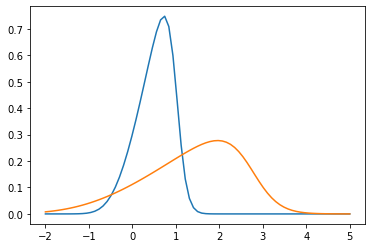

In [8]:
plt.plot(x, u[:, 1])
plt.plot(x, u[:, 24])

In [48]:
np.linalg.lstsq(dataset.library(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1)), dataset.time_deriv(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1)), rcond=None)

(array([[ 3.25620494e-16],
        [ 1.14003858e-15],
        [ 1.00000000e-01],
        [-4.36120324e-17],
        [-2.67505202e-15],
        [-1.00000000e+00],
        [-2.11961525e-16],
        [ 1.28061153e-16],
        [-2.34868006e-15],
        [ 1.82528143e-15],
        [-6.39977437e-16],
        [-8.34293572e-17]]),
 array([2.48667827e-29]),
 12,
 array([2.90126507e+02, 6.59111125e+01, 4.37581086e+01, 3.93362178e+01,
        1.51171245e+01, 7.73448573e+00, 6.66585716e+00, 5.69824772e+00,
        1.43131830e+00, 8.94364043e-01, 4.41301167e-01, 1.89400504e-01]))

# Running deepmod with old version

In [9]:
config = {'n_in': 2, 'hidden_dims': [20, 20, 20, 20], 'n_out': 1, 'library_function':library_1D_in, 'library_args':{'poly_order':2, 'diff_order': 2}}

In [10]:
model = DeepMod(**config)

Let's train without l1 to compare more fair:

In [11]:
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.999), amsgrad=True)

In [12]:
train(model, X_train, y_train, optimizer, 25000, loss_func_args={'l1':0.0})

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |
      25000    100.00%               0s   2.82e-05   1.12e-05   1.69e-05   0.00e+00 

In [13]:
df_baseline = load_tensorboard('runs/Apr14_13-27-35_20eb248f0908/')

In [14]:
df_baseline.keys()

Index(['Total_loss', 'MSE_0', 'Regression_0', 'L1_0', 'coeff_0_0', 'coeff_0_1',
       'coeff_0_2', 'coeff_0_3', 'coeff_0_4', 'coeff_0_5', 'coeff_0_6',
       'coeff_0_7', 'coeff_0_8', 'scaled_coeff_0_0', 'scaled_coeff_0_1',
       'scaled_coeff_0_2', 'scaled_coeff_0_3', 'scaled_coeff_0_4',
       'scaled_coeff_0_5', 'scaled_coeff_0_6', 'scaled_coeff_0_7',
       'scaled_coeff_0_8'],
      dtype='object')

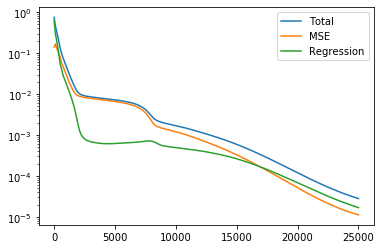

In [15]:
plt.semilogy(df_baseline['Total_loss'], label='Total')
plt.semilogy(df_baseline['MSE_0'], label='MSE')
plt.semilogy(df_baseline['Regression_0'], label='Regression')

plt.legend()

In [16]:
coeff_keys = [key for key in df_baseline.keys() if key[:5]=='coeff']
scaled_coeff_keys = [key for key in df_baseline.keys() if key[:6]=='scaled']

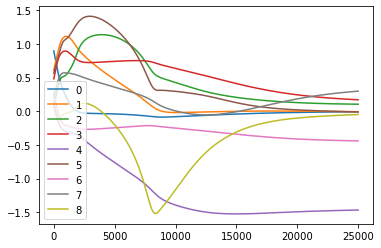

In [17]:
for key in coeff_keys:
    plt.plot(df_baseline[key], label=f'{key[-1]}')
plt.legend()

(-2, 2)

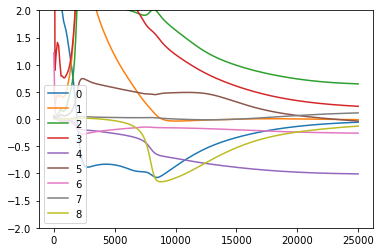

In [19]:
for key in scaled_coeff_keys:
    plt.plot(df_baseline[key], label=f'{key[-1]}')
    
plt.legend()
plt.ylim([-2, 2])

So not too bad.

# Running deepmod with new version

In [20]:
config = {'n_in': 2, 'hidden_dims': [20, 20, 20, 20], 'n_out': 1, 'library_function':library_1D_in, 'library_args':{'poly_order':2, 'diff_order': 2}}

In [21]:
model_dynamic = DeepModDynamic(**config)

Let's train without l1 to compare more fair:

In [22]:
optimizer = torch.optim.Adam(model_dynamic.network_parameters(), betas=(0.99, 0.999), amsgrad=True)

In [23]:
train(model_dynamic, X_train, y_train, optimizer, 25000, loss_func_args={'l1':0.0})

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |
      25000    100.00%               0s   1.14e-05   5.75e-06   5.67e-06   0.00e+00 

In [24]:
model_dynamic.fit.coeff_vector

[tensor([[-6.4383e-04],
         [-7.7157e-03],
         [ 1.0005e-01],
         [ 6.5055e-02],
         [-1.4692e+00],
         [-5.3471e-02],
         [-2.7783e-01],
         [ 4.1713e-01],
         [ 6.0673e-03]], grad_fn=<MmBackward>)]

In [25]:
df_new = load_tensorboard('runs/Apr14_13-33-12_20eb248f0908/')

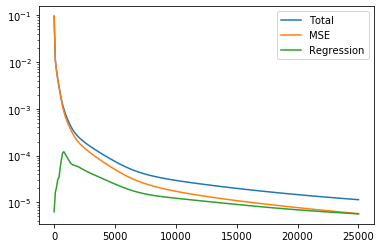

In [26]:
plt.semilogy(df_new['Total_loss'], label='Total')
plt.semilogy(df_new['MSE_0'], label='MSE')
plt.semilogy(df_new['Regression_0'], label='Regression')

plt.legend()

(-1, 1)

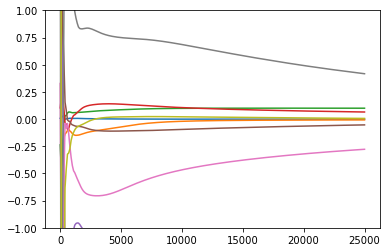

In [89]:
for key in coeff_keys:
    plt.plot(df_new[key])

plt.ylim([-1, 1])

(-2, 1)

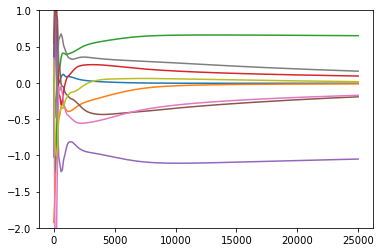

In [91]:
for key in scaled_coeff_keys:
    plt.plot(df_new[key])

plt.ylim([-2, 1])

# Comparing

Text(0.5, 1.0, 'total loss')

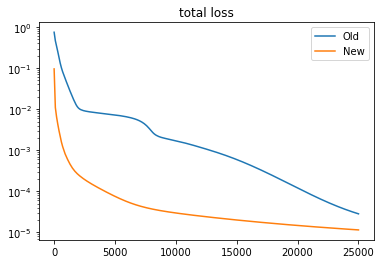

In [27]:
plt.semilogy(df_baseline['Total_loss'], label='Old')
plt.semilogy(df_new['Total_loss'], label='New')
plt.legend()
plt.title('total loss')

Text(0.5, 1.0, 'MSE')

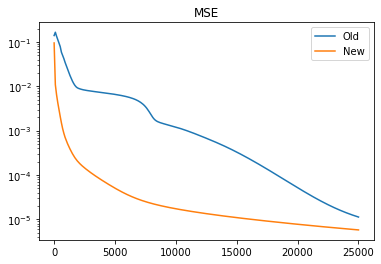

In [28]:
plt.semilogy(df_baseline['MSE_0'], label='Old')
plt.semilogy(df_new['MSE_0'], label='New')
plt.legend()
plt.title('MSE')

Text(0.5, 1.0, 'Regression')

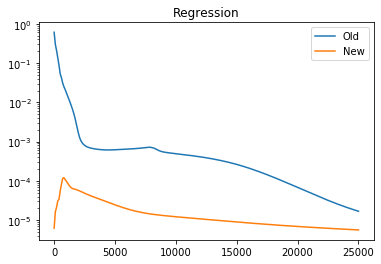

In [29]:
plt.semilogy(df_baseline['Regression_0'], label='Old')
plt.semilogy(df_new['Regression_0'], label='New')
plt.legend()
plt.title('Regression')

Thats a pretty amazing difference. Now let's look at the coefficients:

(-1, 1)

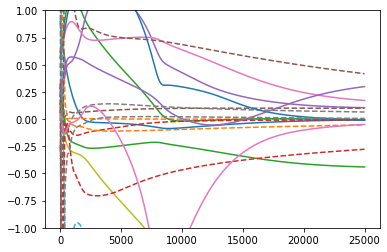

In [30]:
for key in coeff_keys:
    plt.plot(df_baseline[key])
    plt.plot(df_new[key], '--')

plt.ylim([-1, 1])

(-1, 1)

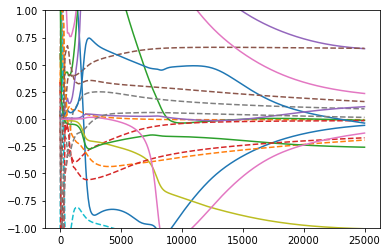

In [31]:
for key in scaled_coeff_keys:
    plt.plot(df_baseline[key])
    plt.plot(df_new[key], '--')

plt.ylim([-1, 1])

Text(0.5, 1.0, 'Scaled Diffusion component')

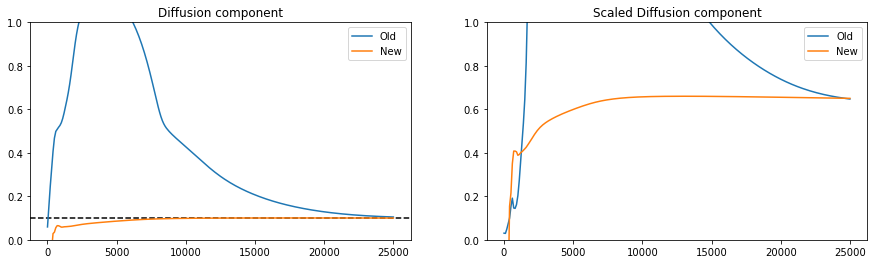

In [40]:
plt.figure(figsize=(15, 4))
plt.subplot(121)
plt.axhline(0.1, color='k', linestyle='--')
plt.plot(df_baseline['coeff_0_2'], label='Old')
plt.plot(df_new['coeff_0_2'], label='New')


plt.legend()
plt.ylim([0, 1.0])
plt.title('Diffusion component')

plt.subplot(122)
plt.plot(df_baseline['scaled_coeff_0_2'], label='Old')
plt.plot(df_new['scaled_coeff_0_2'], label='New')

plt.legend()
plt.ylim([0, 1])
plt.title('Scaled Diffusion component')

Text(0.5, 1.0, 'Scaled Nonlinear component')

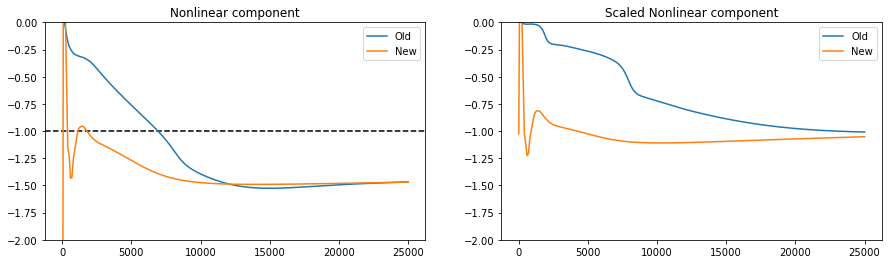

In [42]:
plt.figure(figsize=(15, 4))
plt.subplot(121)
plt.axhline(-1.0, color='k', linestyle='--')
plt.plot(df_baseline['coeff_0_4'], label='Old')
plt.plot(df_new['coeff_0_4'], label='New')

plt.legend()
plt.ylim([-2, 0])
plt.title('Nonlinear component')

plt.subplot(122)
plt.plot(df_baseline['scaled_coeff_0_4'], label='Old')
plt.plot(df_new['scaled_coeff_0_4'], label='New')

plt.legend()
plt.ylim([-2, 0])
plt.title('Scaled Nonlinear component')

So it does well on diffusion, a bit less on the non-linear....

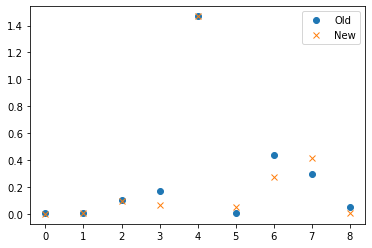

In [35]:
plt.plot(np.abs(df_baseline.tail(1)[coeff_keys].to_numpy().squeeze()), 'o', label='Old')
plt.plot(np.abs(df_new.tail(1)[coeff_keys].to_numpy().squeeze()), 'x', label='New')

plt.legend()

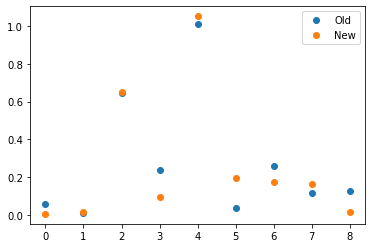

In [36]:
plt.plot(np.abs(df_baseline.tail(1)[scaled_coeff_keys].to_numpy().squeeze()), 'o', label='Old')
plt.plot(np.abs(df_new.tail(1)[scaled_coeff_keys].to_numpy().squeeze()), 'o', label='New')

plt.legend()

# Adding noise

In [118]:
noise_level = 0.05

In [119]:
X_train = torch.tensor(X, dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y + noise_level * np.std(y) * np.random.randn(y.size, 1), dtype=torch.float32, requires_grad=True)

In [120]:
config = {'n_in': 2, 'hidden_dims': [20, 20, 20, 20], 'n_out': 1, 'library_function':library_1D_in, 'library_args':{'poly_order':2, 'diff_order': 2}}

## Old 

In [121]:
model = DeepMod(**config)

Let's train without l1 to compare more fair:

In [122]:
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.999), amsgrad=True)

In [123]:
train(model, X_train, y_train, optimizer, 25000, loss_func_args={'l1':0.0})

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |
      25000    100.00%               0s   7.80e-05   6.39e-05   1.41e-05   0.00e+00 

## New

In [124]:
model_dynamic = DeepModDynamic(**config)

Let's train without l1 to compare more fair:

In [125]:
optimizer = torch.optim.Adam(model_dynamic.network_parameters(), betas=(0.99, 0.999), amsgrad=True)

In [126]:
train(model_dynamic, X_train, y_train, optimizer, 25000, loss_func_args={'l1':0.0})

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |
      25000    100.00%               0s   6.29e-05   5.75e-05   5.33e-06   0.00e+00 

# Comparing high noise

In [127]:
df_baseline = load_tensorboard('runs/Apr15_08-37-31_20eb248f0908/')
df_new = load_tensorboard('runs/Apr15_08-42-26_20eb248f0908/')

Text(0.5, 1.0, 'total loss')

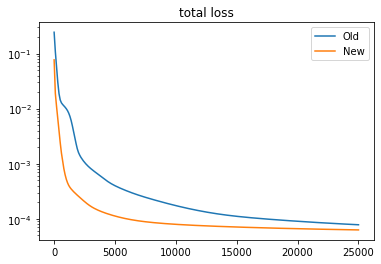

In [128]:
plt.semilogy(df_baseline['Total_loss'], label='Old')
plt.semilogy(df_new['Total_loss'], label='New')
plt.legend()
plt.title('total loss')

Text(0.5, 1.0, 'MSE')

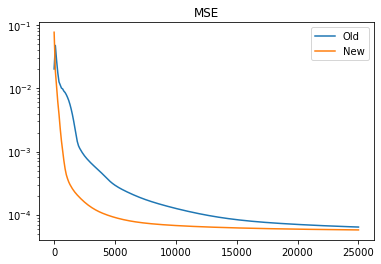

In [129]:
plt.semilogy(df_baseline['MSE_0'], label='Old')
plt.semilogy(df_new['MSE_0'], label='New')
plt.legend()
plt.title('MSE')

Text(0.5, 1.0, 'Regression')

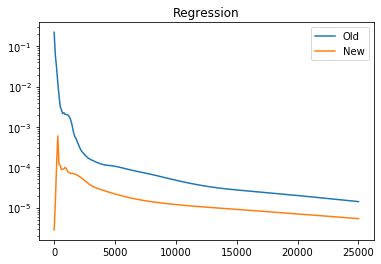

In [130]:
plt.semilogy(df_baseline['Regression_0'], label='Old')
plt.semilogy(df_new['Regression_0'], label='New')
plt.legend()
plt.title('Regression')

Thats a pretty amazing difference. Now let's look at the coefficients:

(-1, 1)

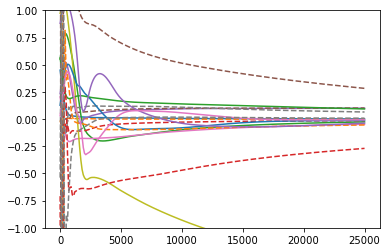

In [131]:
for key in coeff_keys:
    plt.plot(df_baseline[key])
    plt.plot(df_new[key], '--')

plt.ylim([-1, 1])

(-1, 1)

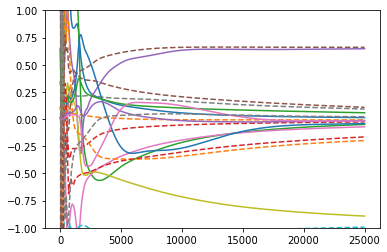

In [132]:
for key in scaled_coeff_keys:
    plt.plot(df_baseline[key])
    plt.plot(df_new[key], '--')

plt.ylim([-1, 1])

Text(0.5, 1.0, 'Scaled Diffusion component')

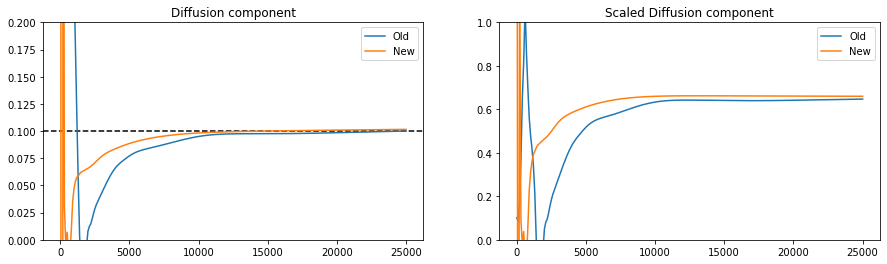

In [134]:
plt.figure(figsize=(15, 4))
plt.subplot(121)
plt.axhline(0.1, color='k', linestyle='--')
plt.plot(df_baseline['coeff_0_2'], label='Old')
plt.plot(df_new['coeff_0_2'], label='New')


plt.legend()
plt.ylim([0, 0.2])
plt.title('Diffusion component')

plt.subplot(122)
plt.plot(df_baseline['scaled_coeff_0_2'], label='Old')
plt.plot(df_new['scaled_coeff_0_2'], label='New')

plt.legend()
plt.ylim([0, 1])
plt.title('Scaled Diffusion component')

Text(0.5, 1.0, 'Scaled Nonlinear component')

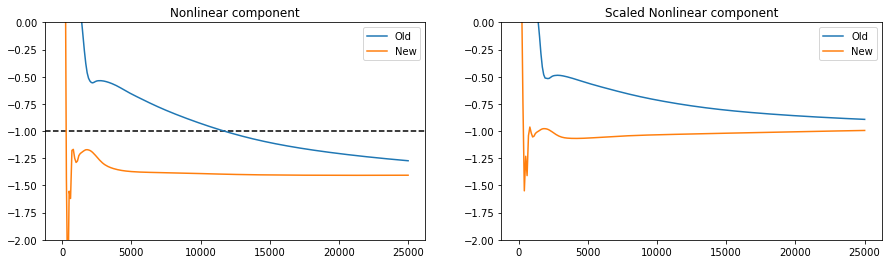

In [135]:
plt.figure(figsize=(15, 4))
plt.subplot(121)
plt.axhline(-1.0, color='k', linestyle='--')
plt.plot(df_baseline['coeff_0_4'], label='Old')
plt.plot(df_new['coeff_0_4'], label='New')

plt.legend()
plt.ylim([-2, 0])
plt.title('Nonlinear component')

plt.subplot(122)
plt.plot(df_baseline['scaled_coeff_0_4'], label='Old')
plt.plot(df_new['scaled_coeff_0_4'], label='New')

plt.legend()
plt.ylim([-2, 0])
plt.title('Scaled Nonlinear component')

So it does well on diffusion, a bit less on the non-linear....

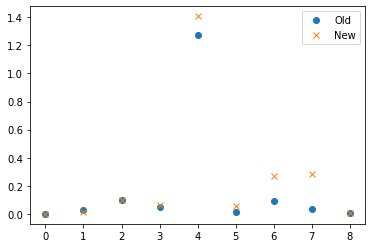

In [136]:
plt.plot(np.abs(df_baseline.tail(1)[coeff_keys].to_numpy().squeeze()), 'o', label='Old')
plt.plot(np.abs(df_new.tail(1)[coeff_keys].to_numpy().squeeze()), 'x', label='New')

plt.legend()

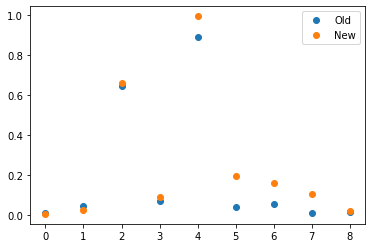

In [137]:
plt.plot(np.abs(df_baseline.tail(1)[scaled_coeff_keys].to_numpy().squeeze()), 'o', label='Old')
plt.plot(np.abs(df_new.tail(1)[scaled_coeff_keys].to_numpy().squeeze()), 'o', label='New')

plt.legend()

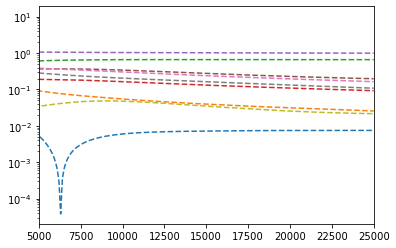

In [174]:
for key in scaled_coeff_keys:
    plt.plot(np.abs(df_new[key]), '--')

#plt.ylim([0.0, 1.0])
plt.xlim([5000, 25000])
plt.yscale('log')

now we also know what reall coeffs should be:

In [180]:
true_coeffs = np.linalg.lstsq(dataset.library(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1)), dataset.time_deriv(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1)), rcond=None)[0].squeeze()

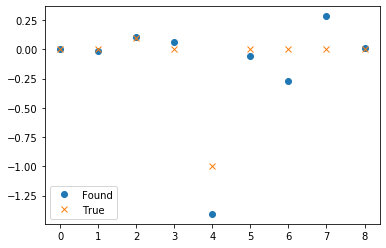

In [196]:
plt.plot(df_new.tail(1)[coeff_keys].to_numpy().squeeze(), 'o', label='Found')
plt.plot(true_coeffs.reshape(3, 4)[:, :3].flatten(), 'x', label='True') # we have to remove 3rd order derivs

plt.legend()

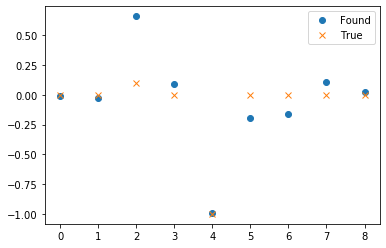

In [197]:
plt.plot(df_new.tail(1)[scaled_coeff_keys].to_numpy().squeeze(), 'o', label='Found')
plt.plot(true_coeffs.reshape(3, 4)[:, :3].flatten(), 'x', label='True') # we have to remove 3rd order derivs

plt.legend()